# Just-in-time Compilation with [Numba](http://numba.pydata.org/) 

In [55]:
import math
import numpy as np
import matplotlib.pyplot as plt
import numba

## Using `numba.jit`

Numba offers `jit` which can used to decorate Python functions.

In [56]:
def is_prime(n):
    if n <= 1:
        raise ArithmeticError(f'"0" <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False
            
    return True

In [57]:
n = np.random.randint(2, 10000000, dtype=np.int64) # Get a random integer between 2 and 10000000

In [58]:
@numba.jit
def is_prime_jitted(n):
    if n <= 1:
        raise ArithmeticError(f'"0" <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False

    return True

In [59]:
numbers = np.random.randint(2, 100000, dtype=np.int64, size=1000)
%time p1 = [is_prime(n) for n in numbers]
%time p2 = [is_prime_jitted(n) for n in numbers]

CPU times: user 6.6 ms, sys: 203 µs, total: 6.8 ms
Wall time: 6.69 ms
CPU times: user 54.1 ms, sys: 3.51 ms, total: 57.6 ms
Wall time: 55.8 ms


## Using `numba.jit` with `nopython=True`

In [60]:
@numba.jit(nopython=True)
def is_prime_njitted(n):
    if n <= 1:
        raise ArithmeticError(f'"0" <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False

    return True

In [61]:
numbers = np.random.randint(2, 100000, dtype=np.int64, size=1000)
%time p1 = [is_prime(n) for n in numbers]
%time p2 = [is_prime_njitted(n) for n in numbers]

CPU times: user 7.18 ms, sys: 0 ns, total: 7.18 ms
Wall time: 7.04 ms
CPU times: user 54.7 ms, sys: 0 ns, total: 54.7 ms
Wall time: 54.2 ms


## Using ` @numba.jit(nopython=True)` is equivalent to using ` @numba.njit`

In [65]:
@numba.jit(nopython=True)
def is_prime_njitted(n):
    if n <= 1:
        raise ArithmeticError(f'"0" <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False

    return True

## Calculating and plotting the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set)

In [67]:
X, Y = np.meshgrid(np.linspace(-2.0, 1, 1000), np.linspace(-1.0, 1.0, 1000))

def mandelbrot(X, Y, itermax):
    mandel = np.empty(shape=X.shape, dtype=np.int32)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            it = 0
            cx = X[i, j]
            cy = Y[i, j]
            x = 0.0
            y = 0.0
            while x * x + y * y < 4.0 and it < itermax:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                it += 1
            mandel[i, j] = it
            
    return mandel

CPU times: user 13.9 s, sys: 0 ns, total: 13.9 s
Wall time: 13.9 s


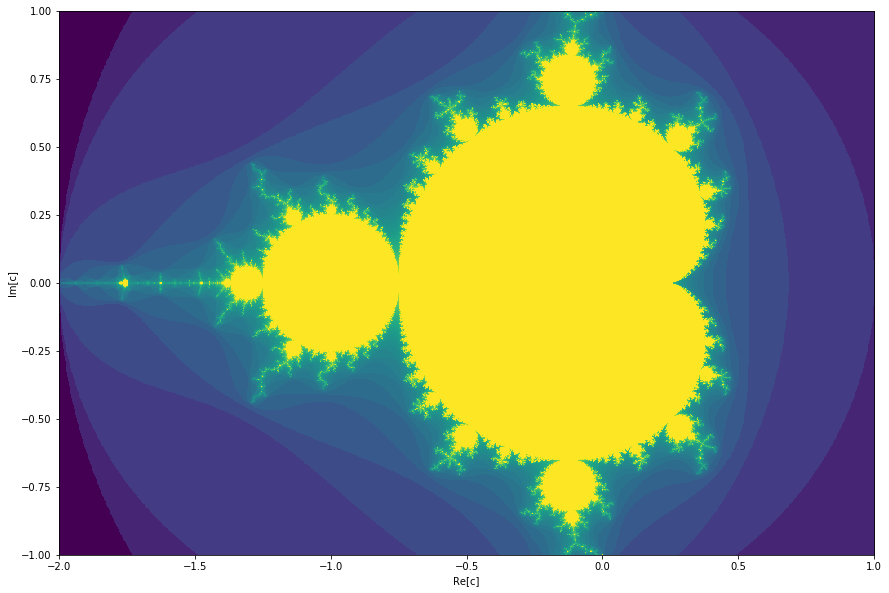

In [68]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

%time m = mandelbrot(X, Y, 100)
    
ax.imshow(np.log(1 + m), extent=[-2.0, 1, -1.0, 1.0]);
ax.set_aspect('equal')
ax.set_ylabel('Im[c]')
ax.set_xlabel('Re[c]');

In [15]:
@numba.njit(parallel=True)
def mandelbrot_jitted(X, Y, radius2, itermax):
    mandel = np.empty(shape=X.shape, dtype=np.int32)
    for i in numba.prange(X.shape[0]):
        for j in range(X.shape[1]):
            it = 0
            cx = X[i, j]
            cy = Y[i, j]
            x = cx
            y = cy
            while x * x + y * y < 4.0 and it < itermax:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                it += 1
            mandel[i, j] = it
            
    return mandel

CPU times: user 105 ms, sys: 0 ns, total: 105 ms
Wall time: 18.1 ms


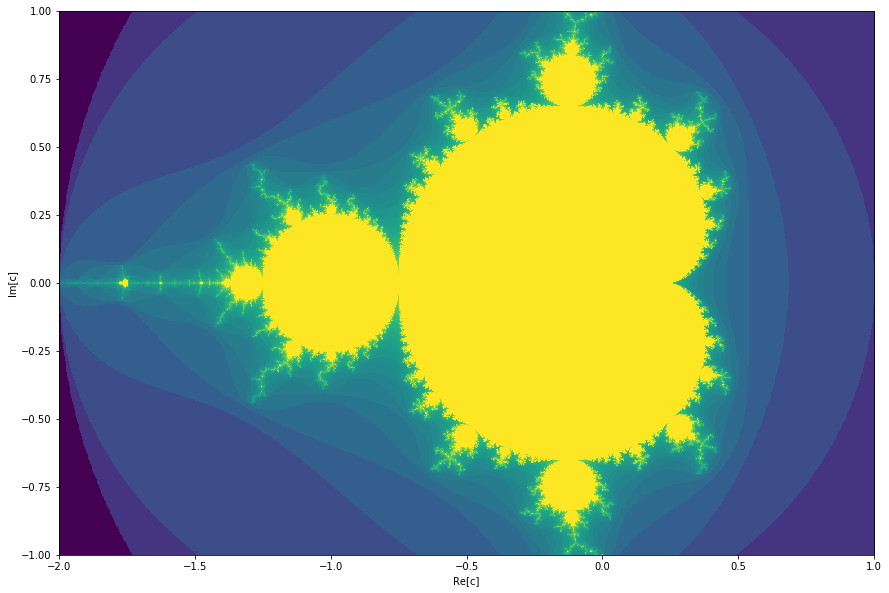

In [69]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)


%time m = mandelbrot_jitted(X, Y, 4.0, 100)
    
ax.imshow(np.log(1 + m), extent=[-2.0, 1, -1.0, 1.0]);
ax.set_aspect('equal')
ax.set_ylabel('Im[c]')
ax.set_xlabel('Re[c]');

### Getting parallelization information

In [71]:
mandelbrot_jitted.parallel_diagnostics(level=3)

 
 Parallel Accelerator Optimizing:  Function mandelbrot_jitted, <ipython-
input-15-238a75aae604> (1)  


Parallel loop listing for  Function mandelbrot_jitted, <ipython-input-15-238a75aae604> (1) 
---------------------------------------------------------------|loop #ID
@numba.njit(parallel=True)                                     | 
def mandelbrot_jitted(X, Y, radius2, itermax):                 | 
    mandel = np.empty(shape=X.shape, dtype=np.int32)           | 
    for i in numba.prange(X.shape[0]):-------------------------| #1
        for j in range(X.shape[1]):                            | 
            it = 0                                             | 
            cx = X[i, j]                                       | 
            cy = Y[i, j]                                       | 
            x = cx                                             | 
            y = cy                                             | 
            while x * x + y * y < 4.0 and it < itermax:        | 
 

## Creating `ufuncs` using `numba.vectorize`

In [18]:
from math import sin
from numba import float64, int64

def my_numpy_sin(a, b):
    return np.sin(a) + np.sin(b)

@np.vectorize
def my_sin(a, b):
    return sin(a) + sin(b)

@numba.vectorize([float64(float64, float64), int64(int64, int64)], target='parallel')
def my_sin_numba(a, b):
    return np.sin(a) + np.sin(b)

In [19]:
x = np.random.randint(0, 100, size=9000000)
y = np.random.randint(0, 100, size=9000000)
print(y.dtype)

%time _ = my_numpy_sin(x, y)
%time _ = my_sin(x, y)
%time _ = my_sin_numba(x, y)

int64
CPU times: user 522 ms, sys: 20.1 ms, total: 542 ms
Wall time: 541 ms
CPU times: user 2.1 s, sys: 128 ms, total: 2.23 s
Wall time: 2.23 s
CPU times: user 705 ms, sys: 69.8 ms, total: 775 ms
Wall time: 167 ms


### Vectorize the testing of prime numbers 

In [42]:
@numba.vectorize('boolean(int64)')
def is_prime_v(n):
    if n <= 1:
        raise ArithmeticError(f'"0" <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False
            
    return True

In [44]:
numbers = np.random.randint(2, 10000000000, dtype=np.int64, size=100000)
%time p = is_prime_v(numbers)

CPU times: user 2.11 s, sys: 0 ns, total: 2.11 s
Wall time: 2.11 s


### Parallelize the vectorized function

In [48]:
@numba.vectorize(['boolean(int64)', 'boolean(int32)'],
                 target='parallel')
def is_prime_vp(n):
    if n <= 1:
        raise ArithmeticError(f'"0" <= 1')
    if n == 2 or n == 3:
        return True
    elif n % 2 == 0:
        return False
    else:
        n_sqrt = math.ceil(math.sqrt(n))
        for i in range(3, n_sqrt):
            if n % i == 0:
                return False
            
    return True

In [51]:
numbers = np.random.randint(2, 10000000000, dtype=np.int64, size=100000)
%time p1 = is_prime_v(numbers)
%time p2 = is_prime_vp(numbers)

CPU times: user 2.05 s, sys: 0 ns, total: 2.05 s
Wall time: 2.05 s
CPU times: user 3.17 s, sys: 0 ns, total: 3.17 s
Wall time: 289 ms


In [54]:
# Print the largest primes from to 1 and 10 millions
numbers = np.arange(1000000, 10000001, dtype=np.int32)
p1 = is_prime_vp(numbers)
primes = numbers[p1]

for n in primes[-10:]:
    print(n)

9999889
9999901
9999907
9999929
9999931
9999937
9999943
9999971
9999973
9999991
